In [6]:
import pandas as pd
import datetime as dt
from typing import List, Dict, Union
import yfinance as yf
import pytz
import time
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm
import json
from matplotlib import pyplot as plt
import requests

In [7]:
# API Client
class AlpacaAPIClient:
    def __init__(self, base_url, api_key, api_secret):
        self.base_url = base_url
        self.headers = {
            "accept": "application/json",
            "content-type": "application/json",
            "APCA-API-KEY-ID": api_key,
            "APCA-API-SECRET-KEY": api_secret,
        }

    def get(self, endpoint, params=None, retries=3, url_part="v2", base="paper"):
        base_url = self.base_url if base == "paper" else "https://data.alpaca.markets"
        for attempt in range(retries):
            try:
                full_url = f"{base_url}/{url_part}{endpoint}"
                response = requests.get(full_url, headers=self.headers, params=params)
                response.raise_for_status()
                return response.json()
            except Exception:
                time.sleep(2**attempt)
        return None

    def post(self, endpoint, payload, retries=3, url_part="v2", base="paper"):
        base_url = self.base_url if base == "paper" else "https://data.alpaca.markets"
        for attempt in range(retries):
            try:
                full_url = f"{base_url}/{url_part}{endpoint}"
                response = requests.post(full_url, headers=self.headers, json=payload)
                response.raise_for_status()
                return response.json()
            except Exception:
                time.sleep(2**attempt)
        return None

    def delete(self, endpoint, retries=3, url_part="v2", base="paper"):
        base_url = self.base_url if base == "paper" else "https://data.alpaca.markets"
        for attempt in range(retries):
            try:
                full_url = f"{base_url}/{url_part}{endpoint}"
                response = requests.delete(full_url, headers=self.headers)
                response.raise_for_status()
                return response.json()
            except Exception:
                time.sleep(2**attempt)
        return None

    def get_asset_price(self, symbol, type="stocks"):
        if type != "stocks" and type != "options":
            raise ValueError("Invalid type. Must be 'stocks' or 'options'")
        endpoint = f"/{type}/{symbol}/trades/latest"
        return self.get(endpoint=endpoint, base="data")['trade']['p']

In [8]:
with open("config.json", "r") as config_file:
    config = json.load(config_file)

API_KEY = config["api_key"]
API_SECRET = config["api_secret"]
BASE_URL = config["base_url"]

api_client = AlpacaAPIClient(BASE_URL, API_KEY, API_SECRET)

price = api_client.get_asset_price("AAPL")

print(price)

216.93


In [9]:
# Utils
eastern = pytz.timezone("America/New_York")



def wait_until(target_time):
    """Wait until the specified datetime."""
    now = dt.datetime.now(eastern)
    sleep_duration = (target_time - now).total_seconds()
    if sleep_duration > 0:
        time.sleep(sleep_duration)
    else:
        print("Target time already passed.")

def get_spx_tickers() -> List[str]:
    try:
        spx_table = pd.read_html(
            "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        )[0]
        return spx_table["Symbol"].tolist()
    except Exception as e:
        print(f"Error fetching S&P 500 tickers: {e}")
        return []

def find_nearest_expiration(expirations: List[str], target_date: dt.datetime) -> str:
    target_date = target_date.replace(tzinfo=None)
    # Convert string dates to datetime only once during comparison
    return min(
        expirations,
        key=lambda exp: abs(dt.datetime.strptime(exp, "%Y-%m-%d") - target_date),
    )


In [10]:
print(get_spx_tickers())

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DAY', 'D

In [11]:
# Earnings Getter
def get_upcoming_earnings(tickers: List[str], days: int = 1) -> pd.DataFrame:
    ticker_earnings = pd.DataFrame(
        columns=[
            "Ticker",
            "Earnings DateTime",
            "Recommendation",
            "Expected Move",
            "Short Leg",
            "Long Leg",
        ]
    )
    now = dt.datetime.now(dt.timezone.utc)
    future_limit = now + dt.timedelta(days=days)
    ny_tz = pytz.timezone("America/New_York")

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            # Fetch earnings dates
            dates = stock.earnings_dates.sort_index()
            if not dates.empty:
                for earnings_date in dates.index:
                    earnings_datetime = (
                        pd.to_datetime(earnings_date)
                        .tz_convert("UTC")
                        .astimezone(ny_tz)
                    )
                    if now < earnings_datetime < future_limit:
                        ticker_earnings = pd.concat(
                            [
                                ticker_earnings,
                                pd.DataFrame(
                                    {
                                        "Ticker": [ticker],
                                        "Earnings DateTime": [earnings_datetime],
                                        "Recommendation": [
                                            None
                                        ],  # Placeholder for recommendation
                                        "Expected Move": [None],
                                        "Short Leg": [
                                            None
                                        ],  # Placeholder for short leg
                                        "Long Leg": [None],  # Placeholder for long leg
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )
        except Exception as e:
            print(f"Error fetching earnings for {ticker}: {e}")

    return ticker_earnings


In [12]:
# Ticker Filter
def get_current_price(ticker):
    todays_data = ticker.history(period="1d")
    if todays_data.empty:
        raise ValueError("No market data available for today.")
    return todays_data["Close"].iloc[0]

def filter_dates(dates):
    today = dt.datetime.today().date()
    cutoff_date = today + dt.timedelta(days=45)

    sorted_dates = sorted(dt.datetime.strptime(date, "%Y-%m-%d").date() for date in dates)

    arr = []
    for i, date in enumerate(sorted_dates):
        if date >= cutoff_date:
            arr = [d.strftime("%Y-%m-%d") for d in sorted_dates[: i + 1]]
            break

    if len(arr) > 0:
        if arr[0] == today.strftime("%Y-%m-%d"):
            return arr[1:]
        return arr

    raise ValueError("No date 45 days or more in the future found.")


def yang_zhang(price_data, window=30, trading_periods=252, return_last_only=True):
    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc**2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc**2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )

    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )

    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + ((window + 1) / (window - 1)))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(np.sqrt) * np.sqrt(
        trading_periods
    )

    if return_last_only:
        return result.iloc[-1]
    else:
        return result.dropna()


def build_term_structure(days, ivs):
    days = np.array(days)
    ivs = np.array(ivs)

    sort_idx = days.argsort()
    days = days[sort_idx]
    ivs = ivs[sort_idx]

    spline = interp1d(days, ivs, kind="linear", fill_value="extrapolate")

    def term_spline(dte):
        if dte < days[0]:
            return ivs[0]
        elif dte > days[-1]:
            return ivs[-1]
        else:
            return float(spline(dte))

    return term_spline


def compute_recommendation(tickers):
    if isinstance(tickers, str):
        tickers = [tickers]

    recommendations = {}

    for ticker in tickers:
        try:
            ticker = ticker.strip().upper()
            if not ticker:
                recommendations[ticker] = "No stock symbol provided."
                continue

            try:
                stock = yf.Ticker(ticker)
                if len(stock.options) == 0:
                    raise KeyError()
            except KeyError:
                recommendations[ticker] = (
                    f"Error: No options found for stock symbol '{ticker}'."
                )
                continue

            exp_dates = list(stock.options)
            try:
                exp_dates = filter_dates(exp_dates)
            except Exception as e:
                recommendations[ticker] = "Error: Not enough option data."
                continue

            options_chains = {}
            for exp_date in exp_dates:
                options_chains[exp_date] = stock.option_chain(exp_date)

            try:
                underlying_price = get_current_price(stock)
                if underlying_price is None:
                    raise ValueError("No market price found.")
            except Exception as e:
                recommendations[ticker] = (
                    "Error: Unable to retrieve underlying stock price."
                )
                continue

            atm_iv = {}
            straddle = None
            i = 0
            for exp_date, chain in options_chains.items():
                calls = chain.calls
                puts = chain.puts

                if calls.empty or puts.empty:
                    continue

                call_diffs = (calls["strike"] - underlying_price).abs()
                call_idx = call_diffs.idxmin()
                call_iv = calls.loc[call_idx, "impliedVolatility"]

                put_diffs = (puts["strike"] - underlying_price).abs()
                put_idx = put_diffs.idxmin()
                put_iv = puts.loc[put_idx, "impliedVolatility"]

                atm_iv_value = (call_iv + put_iv) / 2.0
                atm_iv[exp_date] = atm_iv_value

                if i == 0:
                    call_bid = calls.loc[call_idx, "bid"]
                    call_ask = calls.loc[call_idx, "ask"]
                    put_bid = puts.loc[put_idx, "bid"]
                    put_ask = puts.loc[put_idx, "ask"]

                    if call_bid is not None and call_ask is not None:
                        call_mid = (call_bid + call_ask) / 2.0
                    else:
                        call_mid = None

                    if put_bid is not None and put_ask is not None:
                        put_mid = (put_bid + put_ask) / 2.0
                    else:
                        put_mid = None

                    if call_mid is not None and put_mid is not None:
                        straddle = call_mid + put_mid

                i += 1

            if not atm_iv:
                recommendations[ticker] = (
                    "Error: Could not determine ATM IV for any expiration dates."
                )
                continue

            today = dt.datetime.today().date()
            dtes = []
            ivs = []
            for exp_date, iv in atm_iv.items():
                exp_date_obj = dt.datetime.strptime(exp_date, "%Y-%m-%d").date()
                days_to_expiry = (exp_date_obj - today).days
                dtes.append(days_to_expiry)
                ivs.append(iv)

            term_spline = build_term_structure(dtes, ivs)

            ts_slope_0_45 = (term_spline(45) - term_spline(dtes[0])) / (45 - dtes[0])

            price_history = stock.history(period="3mo")
            iv30_rv30 = term_spline(30) / yang_zhang(price_history)

            avg_volume = price_history["Volume"].rolling(30).mean().dropna().iloc[-1]

            expected_move = (
                round(straddle / underlying_price * 100, 2) if straddle else None
            )

            avg_volume_bool = avg_volume >= 1500000
            iv30_rv30_bool = iv30_rv30 >= 1.25
            ts_slope_bool = ts_slope_0_45 <= -0.00406

            if avg_volume_bool and iv30_rv30_bool and ts_slope_bool:
                recommendations[ticker] = {
                    "Recommendation": "Recommended",
                    "Expected Move": expected_move,
                }
            elif ts_slope_bool and (avg_volume_bool or iv30_rv30_bool):
                recommendations[ticker] = {
                    "Recommendation": "Consider",
                    "Expected Move": expected_move,
                }
            else:
                recommendations[ticker] = None

        except Exception as e:
            recommendations[ticker] = f"Error occurred processing {ticker}: {str(e)}"

    return recommendations


def process_tickers(df):
    results = compute_recommendation(df["Ticker"])
    for ticker, result in results.items():
        if result is None:
            df = df[df["Ticker"] != ticker]
        else:
            df.loc[df["Ticker"] == ticker, "Recommendation"] = result["Recommendation"]
            df.loc[df["Ticker"] == ticker, "Expected Move"] = result["Expected Move"]

    return df


In [13]:
def find_option_strategy(ticker: str, earnings_date: dt.datetime, client: AlpacaAPIClient) -> Union[Dict[str, Dict[str, str]], None]:
    try:
        print(f"Starting to find option strategy for ticker: {ticker}")
        
        # Fetch expiration dates using Alpaca API
        stock = yf.Ticker(ticker)
        options = stock.options
        expirations = list(options)
         
        print(f"Fetched expiration dates for {ticker}: {expirations}")
        
        current_price = client.get_asset_price(ticker)
        print(f"Current price for {ticker}: {current_price}")
        
        # Find near-term and long-term expirations
        near_term_expiry = find_nearest_expiration(
            expirations, earnings_date + dt.timedelta(days=10)
        )
        print(f"Near-term expiration date for {ticker}: {near_term_expiry}")
        
        long_term_expiry = find_nearest_expiration(
            expirations, dt.datetime.strptime(near_term_expiry, "%Y-%m-%d") + dt.timedelta(days=30)
        )
        print(f"Long-term expiration date for {ticker}: {long_term_expiry}")

        # Fetch options data from Alpaca API
        print(f"Fetching near-term options for {ticker} with expiration {near_term_expiry}")
        near_term_options = client.get(
            f"/options/contracts",
            params={"underlying_symbols": ticker, "expiration_date": near_term_expiry, "type": "call"}
        )
        print(near_term_options)
        
        print(f"Fetching long-term options for {ticker} with expiration {long_term_expiry}")
        long_term_options = client.get(
            f"/options/contracts",
            params={"underlying_symbols": ticker, "expiration_date": long_term_expiry, "type": "call"}
        )
        print(long_term_options)

        # Check if data was retrieved successfully
        if near_term_options is None or long_term_options is None:
            print("Failed to fetch options data from Alpaca.")
            return None

        print(f"Successfully fetched options data for {ticker}")

        # Find the strike closest to the current price
        long_term_strike = min(
            long_term_options["option_contracts"],
            key=lambda x: abs(float(x["strike_price"]) - current_price),
        )
        print(f"Closest strike price to current price for long-term options: {long_term_strike['strike_price']}")

        # Extract the corresponding option contracts
        long_call = next(
            option for option in long_term_options["option_contracts"]
            if float(option["strike_price"]) == float(long_term_strike["strike_price"])
        )
        print(f"Selected long-term call option: {long_call}")
        
        near_call = next(
            option for option in near_term_options["option_contracts"]
            if float(option["strike_price"]) == float(long_term_strike["strike_price"])
        )
        print(f"Selected near-term call option: {near_call}")
        
        # Return the fetched data
        print(f"Option strategy successfully found for {ticker}")
        return {
            "near_term": near_call,
            "long_term": long_call
        }

    except Exception as e:
        print(f"Error in find_option_strategy for {ticker}: {e}")
        return None


In [14]:
def is_spread_worth_it(short_leg, long_leg, ratio_threshold=1.25):
    cost = api_client.get_asset_price(long_leg["symbol"], type="options") - api_client.get_asset_price(long_leg["symbol"], type="options")
    avg_profit = estimate_avg_profit(short_leg, long_leg)
    return ( avg_profit / cost )

def estimate_avg_profit(short_leg, long_leg):
    strike = short_leg['strike_price']
    expiration_date = dt.datetime.strptime(short_leg['expiration_date'], "%Y-%m-%d")
    today = dt.datetime.today()
    T = (expiration_date - today).days / 365.0

    def black_scholes_call(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    S_range = np.linspace(0.5 * strike, 1.5 * strike, 500)
    short_payoff = np.maximum(S_range - strike, 0)
    long_value = black_scholes_call(S_range, long_leg['strike_price'], T, 0.01, long_leg['implied_volatility'])
    pnl = long_value - short_payoff - api_client.get_asset_price(long_leg["symbol"], type="options") - api_client.get_asset_price(long_leg["symbol"], type="options")

    breakeven_zone = pnl >= 0
    avg_profit = np.mean(pnl[breakeven_zone])
    return avg_profit

In [15]:
with open("config.json", "r") as config_file:
    config = json.load(config_file)

API_KEY = config["api_key"]
API_SECRET = config["api_secret"]
BASE_URL = config["base_url"]

api_client = AlpacaAPIClient(BASE_URL, API_KEY, API_SECRET)

price = api_client.get_asset_price("AAPL")

find_option_strategy("AAPL", dt.datetime(2025, 4, 3), api_client)

KeyboardInterrupt: 

In [ ]:
# # Trader
# with open("config.json", "r") as config_file:
#     config = json.load(config_file)

# API_KEY = config["api_key"]
# API_SECRET = config["api_secret"]
# BASE_URL = config["base_url"]
# MARKET_CLOSE_TIME = config["market_close_time"]
# MARKET_OPEN_TIME = config["market_open_time"]
# DEFAULT_LIMIT_PRICE = config["default_limit_price"]

# api_client = AlpacaAPIClient(BASE_URL, API_KEY, API_SECRET)

# eastern = pytz.timezone("America/New_York")



# def find_option_symbol(symbol, strike, expiration_date):

#     endpoint = f"/options/contracts?underlying_symbols={symbol}&expiration_date={expiration_date}"
#     data = api_client.get(endpoint)
#     if data:
#         for contract in data.get("option_contracts", []):
#             if float(contract["strike_price"]) == strike:
#                 return contract["symbol"]
#     return ""


# def trade_calendar_spread(long_symbol: str, short_symbol: str, qty: int) -> None:


#     payload = {
#         "type": "limit",
#         "time_in_force": "day",
#         "order_class": "mleg",
#         "limit_price": DEFAULT_LIMIT_PRICE,  # Adjust as needed
#         "qty": str(qty),
#         "legs": [
#             {
#                 "side": "buy",
#                 "position_intent": "buy_to_open",
#                 "symbol": long_symbol,
#                 "ratio_qty": str(qty),
#             },
#             {
#                 "side": "sell",
#                 "position_intent": "sell_to_open",
#                 "symbol": short_symbol,
#                 "ratio_qty": str(qty),
#             },
#         ],
#     }
#     try:
#         response = api_client.post(endpoint="/orders", payload=payload)
#         if response:
#             print("Order submitted successfully.")
#         else:
#             print("Failed to submit order.")
#     except Exception as e:
#         print(f"Error submitting order: {e}")


# def close_all_positions() -> None:
#     result = api_client.delete("/positions")
#     if result is not None:
#         print("Positions closed successfully.")
#     else:
#         print("Failed to close positions.")

# def get_todays_trades() -> pd.DataFrame:
#     tickers = get_spx_tickers()
#     upcoming = get_upcoming_earnings(tickers)
#     df = process_tickers(upcoming)
#     for index, row in df.iterrows():
#         strat = apca_options_getter(row[0], row[1], api_client)
#         if isinstance(strat, str):
#             df.drop(index, inplace=True)
#             continue
#         df.at[index, "Short Leg"] = strat["near_term"]
#         df.at[index, "Long Leg"] = strat["long_term"]

#     return df[~df["Short Leg"].isnull() & ~df["Long Leg"].isnull()]


# def trader() -> None:
#     """
#     Daily schedule:
#     - At 15 minutes before market close (assumed at 16:00), run the trade finder
#       to process only earnings events scheduled between today's close and next day's open.
#     - Then, on the next trading day at 15 minutes after market open (assumed at 9:30),
#       close all positions.
#     """
#     while True:
#         now = dt.datetime.now(eastern)

#         # Assume market close at 16:00 local time
#         market_close = eastern.localize(
#             dt.datetime(now.year, now.month, now.day, MARKET_CLOSE_TIME)
#         )
#         trade_exec_time = market_close - dt.timedelta(minutes=15)  # 15 min before close

#         # Wait until trade execution time if needed
#         if now < trade_exec_time:
#             wait_until(trade_exec_time)

#         # Compute next day's market open (assumed at 9:30)
#         next_day = now + dt.timedelta(days=1)
#         next_market_open = eastern.localize(
#             dt.datetime(next_day.year, next_day.month, next_day.day, MARKET_OPEN_TIME)
#         )

#         try:
#             trades = get_todays_trades()
#         except Exception as e:
#             trades = pd.DataFrame()

#         if not trades.empty:
#             trades.to_csv("calendar_spreads.csv", index=False)
#             for _, row in trades.iterrows():
#                 ticker = row["Ticker"]
#                 short_call = row["Short Leg"]
#                 long_call = row["Long Leg"]
#                 qty = 1

#                 long_symbol = long_call["symbol"]
#                 short_symbol = short_call["symbol"]

#                 if not short_symbol or not long_symbol:
#                     continue

#                 trade_calendar_spread(long_symbol, short_symbol, qty)
#         else:
#             print("No trades found.")

#         # Wait until next trading day at 15 minutes after market open to close positions
#         close_positions_time = next_market_open + dt.timedelta(minutes=45)
#         sleep_duration = (
#             close_positions_time - dt.datetime.now(eastern)
#         ).total_seconds()
#         if sleep_duration > 0:
#             wait_until(close_positions_time)
#         else:
#             print("Market already open.")
            
#         close_all_positions()

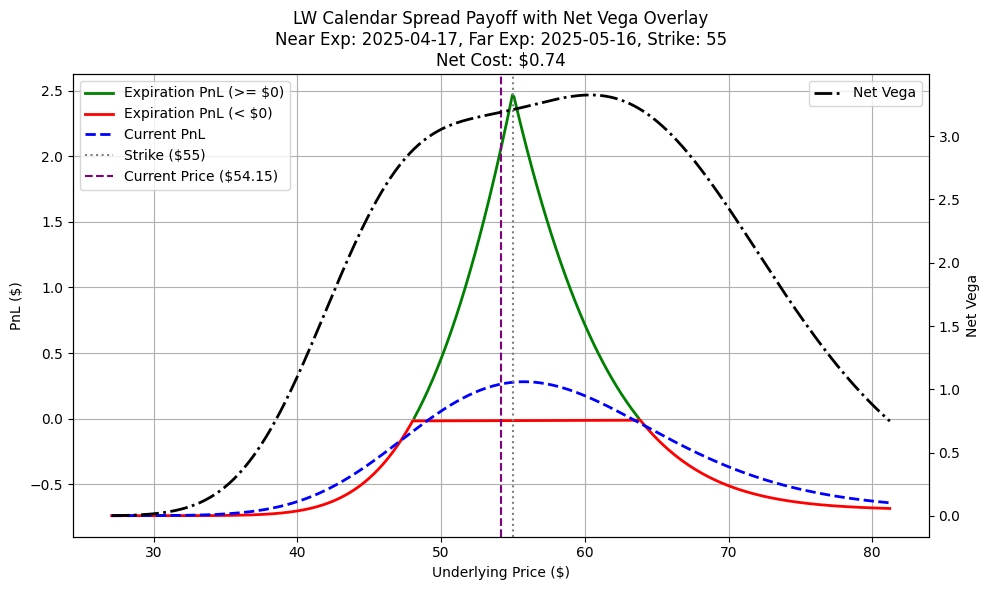

In [30]:
# Plotter
def plot_calendar_spread(df):
    for i in range(len(df)):   
        # --------------------------
        # Parameters (adjust as needed)
        # --------------------------
        ticker = df.loc[0, 'Ticker']                      # Underlying ticker symbol
        near_exp = df.loc[0, 'Short Call']['expiry']        # Near-term option expiration (short call)
        far_exp = df.loc[0, 'Long Call']['expiry']          # Far-term option expiration (long call)
        strike = df.loc[0, 'Short Call']['strike']          # Option strike price (assumed same for both)

        # --------------------------
        # Fetch Market Data using yfinance
        # --------------------------
        yf_ticker = yf.Ticker(ticker)
        current_underlying = yf_ticker.info['regularMarketPrice']

        # --- Near-Term (Short Call) ---
        option_chain_near = yf_ticker.option_chain(near_exp)
        calls_near = option_chain_near.calls
        idx_near = (calls_near['strike'] - strike).abs().idxmin()
        selected_option_near = calls_near.loc[idx_near]
        premium_short = selected_option_near['lastPrice']
        implied_vol_near = selected_option_near['impliedVolatility']
        if np.isnan(implied_vol_near) or implied_vol_near == 0:
            implied_vol_near = 0.2  # default to 20%

        # --- Far-Term (Long Call) ---
        option_chain_far = yf_ticker.option_chain(far_exp)
        calls_far = option_chain_far.calls
        idx_far = (calls_far['strike'] - strike).abs().idxmin()
        selected_option_far = calls_far.loc[idx_far]
        premium_long = selected_option_far['lastPrice']
        implied_vol_far = selected_option_far['impliedVolatility']
        if np.isnan(implied_vol_far) or implied_vol_far == 0:
            implied_vol_far = 0.2  # default to 20%

        # --------------------------
        # Calculate Time to Expiration (in years)
        # --------------------------
        expiration_dt_near = dt.datetime.strptime(near_exp, '%Y-%m-%d')
        expiration_dt_far = dt.datetime.strptime(far_exp, '%Y-%m-%d')
        today_dt = dt.datetime.today()
        T1 = (expiration_dt_near - today_dt).days / 365.0  # Time until near expiration
        T2 = (expiration_dt_far - today_dt).days / 365.0     # Time until far expiration
        if T1 <= 0:
            raise ValueError("The near-term option has already expired.")
        if T2 <= 0:
            raise ValueError("The far-term option has already expired.")

        # --------------------------
        # Net Premium (Debit/Credit) for the Calendar Spread
        # --------------------------
        net_cost = premium_long - premium_short

        # --------------------------
        # Black-Scholes Call Option Pricing and Vega Formulas
        # --------------------------
        def black_scholes_call(S, K, T, r, sigma):
            d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

        def call_vega(S, K, T, r, sigma):
            d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
            return S * np.sqrt(T) * norm.pdf(d1)

        # --------------------------
        # Generate Underlying Price Range for Plotting
        # --------------------------
        S_range = np.linspace(0.5 * current_underlying, 1.5 * current_underlying, 500)

        # --------------------------
        # Calculate PnL Curves for Calendar Spread
        # --------------------------
        # At near-term expiration (T1):
        expiration_long_value = black_scholes_call(S_range, strike, T2 - T1, 0.01, implied_vol_far)
        short_payoff = np.maximum(S_range - strike, 0)
        expiration_pnl = expiration_long_value - short_payoff - net_cost

        # Current PnL (as of today):
        current_long_value = black_scholes_call(S_range, strike, T2, 0.01, implied_vol_far)
        current_short_value = black_scholes_call(S_range, strike, T1, 0.01, implied_vol_near)
        current_pnl = current_long_value - current_short_value - net_cost

        # --------------------------
        # Calculate Net Vega for the Spread
        # --------------------------
        vega_short = call_vega(S_range, strike, T1, 0.01, implied_vol_near)
        vega_long = call_vega(S_range, strike, T2, 0.01, implied_vol_far)
        net_vega = vega_long - vega_short

        # --------------------------
        # Plot PnL and Overlay Net Vega (using a secondary y-axis)
        # --------------------------
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax2 = ax1.twinx()  # Secondary y-axis for net vega

        # Plot PnL curves on primary y-axis (ax1)
        above_zero = expiration_pnl >= 0
        below_zero = expiration_pnl < 0
        ax1.plot(S_range[above_zero], expiration_pnl[above_zero], color='green', linewidth=2, label='Expiration PnL (>= $0)')
        ax1.plot(S_range[below_zero], expiration_pnl[below_zero], color='red', linewidth=2, label='Expiration PnL (< $0)')
        ax1.plot(S_range, current_pnl, 'b--', linewidth=2, label='Current PnL')
        ax1.axvline(x=strike, color='gray', linestyle=':', linewidth=1.5, label=f'Strike (${strike})')
        ax1.axvline(x=current_underlying, color='purple', linestyle='--', linewidth=1.5, label=f'Current Price (${current_underlying})')

        ax1.set_xlabel('Underlying Price ($)')
        ax1.set_ylabel('PnL ($)')
        ax1.set_title(f'{ticker} Calendar Spread Payoff with Net Vega Overlay\nNear Exp: {near_exp}, Far Exp: {far_exp}, Strike: {strike}\nNet Cost: ${net_cost:.2f}')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        # Plot net vega on the secondary y-axis (ax2) without altering its appearance
        ax2.plot(S_range, net_vega, 'k-.', linewidth=2, label='Net Vega')
        ax2.set_ylabel('Net Vega')
        ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    # Example usage
    df = pd.DataFrame({
        'Ticker': ['LW'],
        'Short Call': [{'expiry': '2025-04-17', 'strike': 55}],
        'Long Call': [{'expiry': '2025-05-16', 'strike': 55}]
    })
    plot_calendar_spread(df)


In [ ]:
poti =  {'id': 'af25d1ae-fcde-4c98-8e9a-7f6b120ac86f', 'client_order_id': '46a2d344-4637-4335-8a5f-c803e97c8cd9', 'created_at': '2025-04-02T19:46:09.584180117Z', 'updated_at': '2025-04-02T19:46:09.586257867Z', 'submitted_at': '2025-04-02T19:46:09.584180117Z', 'filled_at': None, 'expired_at': None, 'canceled_at': None, 'failed_at': None, 'replaced_at': None, 'replaced_by': None, 'replaces': None, 'asset_id': '', 'symbol': '', 'asset_class': '', 'notional': None, 'qty': '1', 'filled_qty': '0', 'filled_avg_price': None, 'order_class': 'mleg', 'order_type': 'market', 'type': 'market', 'side': '', 'time_in_force': 'day', 'limit_price': None, 'stop_price': None, 'status': 'pending_new', 'extended_hours': False, 'legs': [{'id': '73297301-81fd-40d4-ab95-7c584c9e9c42', 'client_order_id': '75c86272-35ac-43d1-b08f-007ead1d0b41', 'created_at': '2025-04-02T19:46:09.584180117Z', 'updated_at': '2025-04-02T19:46:09.586264467Z', 'submitted_at': '2025-04-02T19:46:09.584180117Z', 'filled_at': None, 'expired_at': None, 'canceled_at': None, 'failed_at': None, 'replaced_at': None, 'replaced_by': None, 'replaces': None, 'asset_id': '3dd160fc-3a56-4113-a746-66f0081acde3', 'symbol': 'LW250516C00055000', 'asset_class': 'us_option', 'notional': None, 'qty': '1', 'filled_qty': '0', 'filled_avg_price': None, 'order_class': 'mleg', 'order_type': 'market', 'type': 'market', 'side': 'buy', 'position_intent': 'buy_to_open', 'time_in_force': 'day', 'limit_price': None, 'stop_price': None, 'status': 'pending_new', 'extended_hours': False, 'legs': None, 'trail_percent': None, 'trail_price': None, 'hwm': None, 'subtag': None, 'source': None, 'expires_at': '2025-04-02T20:00:00Z', 'ratio_qty': '1'}, {'id': '2c0cd588-c1c8-4541-b3e8-1cad0bb4625f', 'client_order_id': '22642525-7237-4fa0-8b20-ea706e0990fe', 'created_at': '2025-04-02T19:46:09.584180117Z', 'updated_at': '2025-04-02T19:46:09.586281587Z', 'submitted_at': '2025-04-02T19:46:09.584180117Z', 'filled_at': None, 'expired_at': None, 'canceled_at': None, 'failed_at': None, 'replaced_at': None, 'replaced_by': None, 'replaces': None, 'asset_id': '366b5448-368b-4a23-b807-776e765789af', 'symbol': 'LW250417C00055000', 'asset_class': 'us_option', 'notional': None, 'qty': '1', 'filled_qty': '0', 'filled_avg_price': None, 'order_class': 'mleg', 'order_type': 'market', 'type': 'market', 'side': 'sell', 'position_intent': 'sell_to_open', 'time_in_force': 'day', 'limit_price': None, 'stop_price': None, 'status': 'pending_new', 'extended_hours': False, 'legs': None, 'trail_percent': None, 'trail_price': None, 'hwm': None, 'subtag': None, 'source': None, 'expires_at': '2025-04-02T20:00:00Z', 'ratio_qty': '1'}], 'trail_percent': None, 'trail_price': None, 'hwm': None, 'subtag': None, 'source': None, 'expires_at': '2025-04-02T20:00:00Z'}

KeyError: 'Short Leg'